In [88]:
import numpy as np
import pandas as pd
import statsmodels
import tensorflow as tf
from datetime import date
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler, StandardScaler

%matplotlib inline

In [58]:
def prepare_data(data, sequence):
    data = data.set_index("Date")
    data["Year"] = data.index.year
    data["Month"] = data.index.month
    data["Weekday"] = data.index.weekday
    data = data.reindex(columns=sequence)
    return data

In [59]:
def plot_time_series(data_info, x_label, y_label, title):
    plt.figure(figsize=(12.80, 7.20), dpi=200)
    for data, color, label in data_info:
        plt.plot(data, color=color, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [60]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back, 0]
        data_x.append(data_window)
        data_y.append(data[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

In [61]:
ether_data = pd.read_csv("Datasets/ETHUSD_Bitfinex_H_historical.csv")
ether_data.drop(labels=["Pair", "Volume_USD"], axis=1, inplace=True)
ether_data.rename(columns={"Volume_CCY":"Volume"}, inplace=True)
ether_data["Date"] = ether_data["TimeStamp"].apply(lambda timestamp: date.fromtimestamp(timestamp)).astype("datetime64")
ether_data.drop(labels="TimeStamp", axis=1, inplace=True)
column_sequence = ["Year", "Month", "Weekday", "Open", "High", "Low", "Close", "Volume"]
ether_data = prepare_data(ether_data, column_sequence)
ether_data = ether_data.sort_values("Date")

In [62]:
ether_data

,Year,Month,Weekday,Open,High,Low,Close,Volume
Date,,,,,,,,
2018-05-15,2018,5,1,733.12,736.480000,731.19,733.04,5782.270000
2018-05-15,2018,5,1,723.64,726.170000,713.44,716.54,5952.150000
2018-05-15,2018,5,1,717.43,728.000000,716.00,723.64,8022.880000
2018-05-15,2018,5,1,711.72,722.020000,709.28,717.43,15166.140000
2018-05-15,2018,5,1,729.61,729.610000,707.43,711.72,22121.080000
...,...,...,...,...,...,...,...,...
2021-02-19,2021,2,4,1922.20,1940.700000,1914.10,1937.00,3072.434510
2021-02-19,2021,2,4,1936.90,1948.845968,1935.10,1944.50,2987.193974
2021-02-19,2021,2,4,1944.40,1946.900000,1932.20,1937.70,1205.782414


In [63]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24259 entries, 2018-05-15 to 2021-02-19
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     24259 non-null  int64  
 1   Month    24259 non-null  int64  
 2   Weekday  24259 non-null  int64  
 3   Open     24259 non-null  float64
 4   High     24259 non-null  float64
 5   Low      24259 non-null  float64
 6   Close    24259 non-null  float64
 7   Volume   24259 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 1.7 MB


In [64]:
ether_data.describe()

,Year,Month,Weekday,Open,High,Low,Close,Volume
count,24259.000000,24259.000000,24259.000000,24259.000000,24259.000000,24259.000000,24259.000000,24259.000000
mean,2019.231625,6.770312,2.998186,315.233035,317.374909,312.916600,315.281518,6982.680290
std,0.855344,3.469703,1.998061,282.922219,285.656912,279.968067,283.098784,13236.317748
min,2018.000000,1.000000,0.000000,83.560000,84.340000,83.000000,83.560000,0.000000
25%,2019.000000,4.000000,1.000000,168.140000,169.085000,167.205000,168.140000,1299.480000
50%,2019.000000,7.000000,3.000000,218.800000,220.140000,217.270000,218.800000,3043.060000
75%,2020.000000,10.000000,5.000000,373.450000,375.060000,371.095000,373.450000,7314.860000
max,2021.000000,12.000000,6.000000,1944.400000,1948.845968,1935.100000,1944.500000,457244.560000


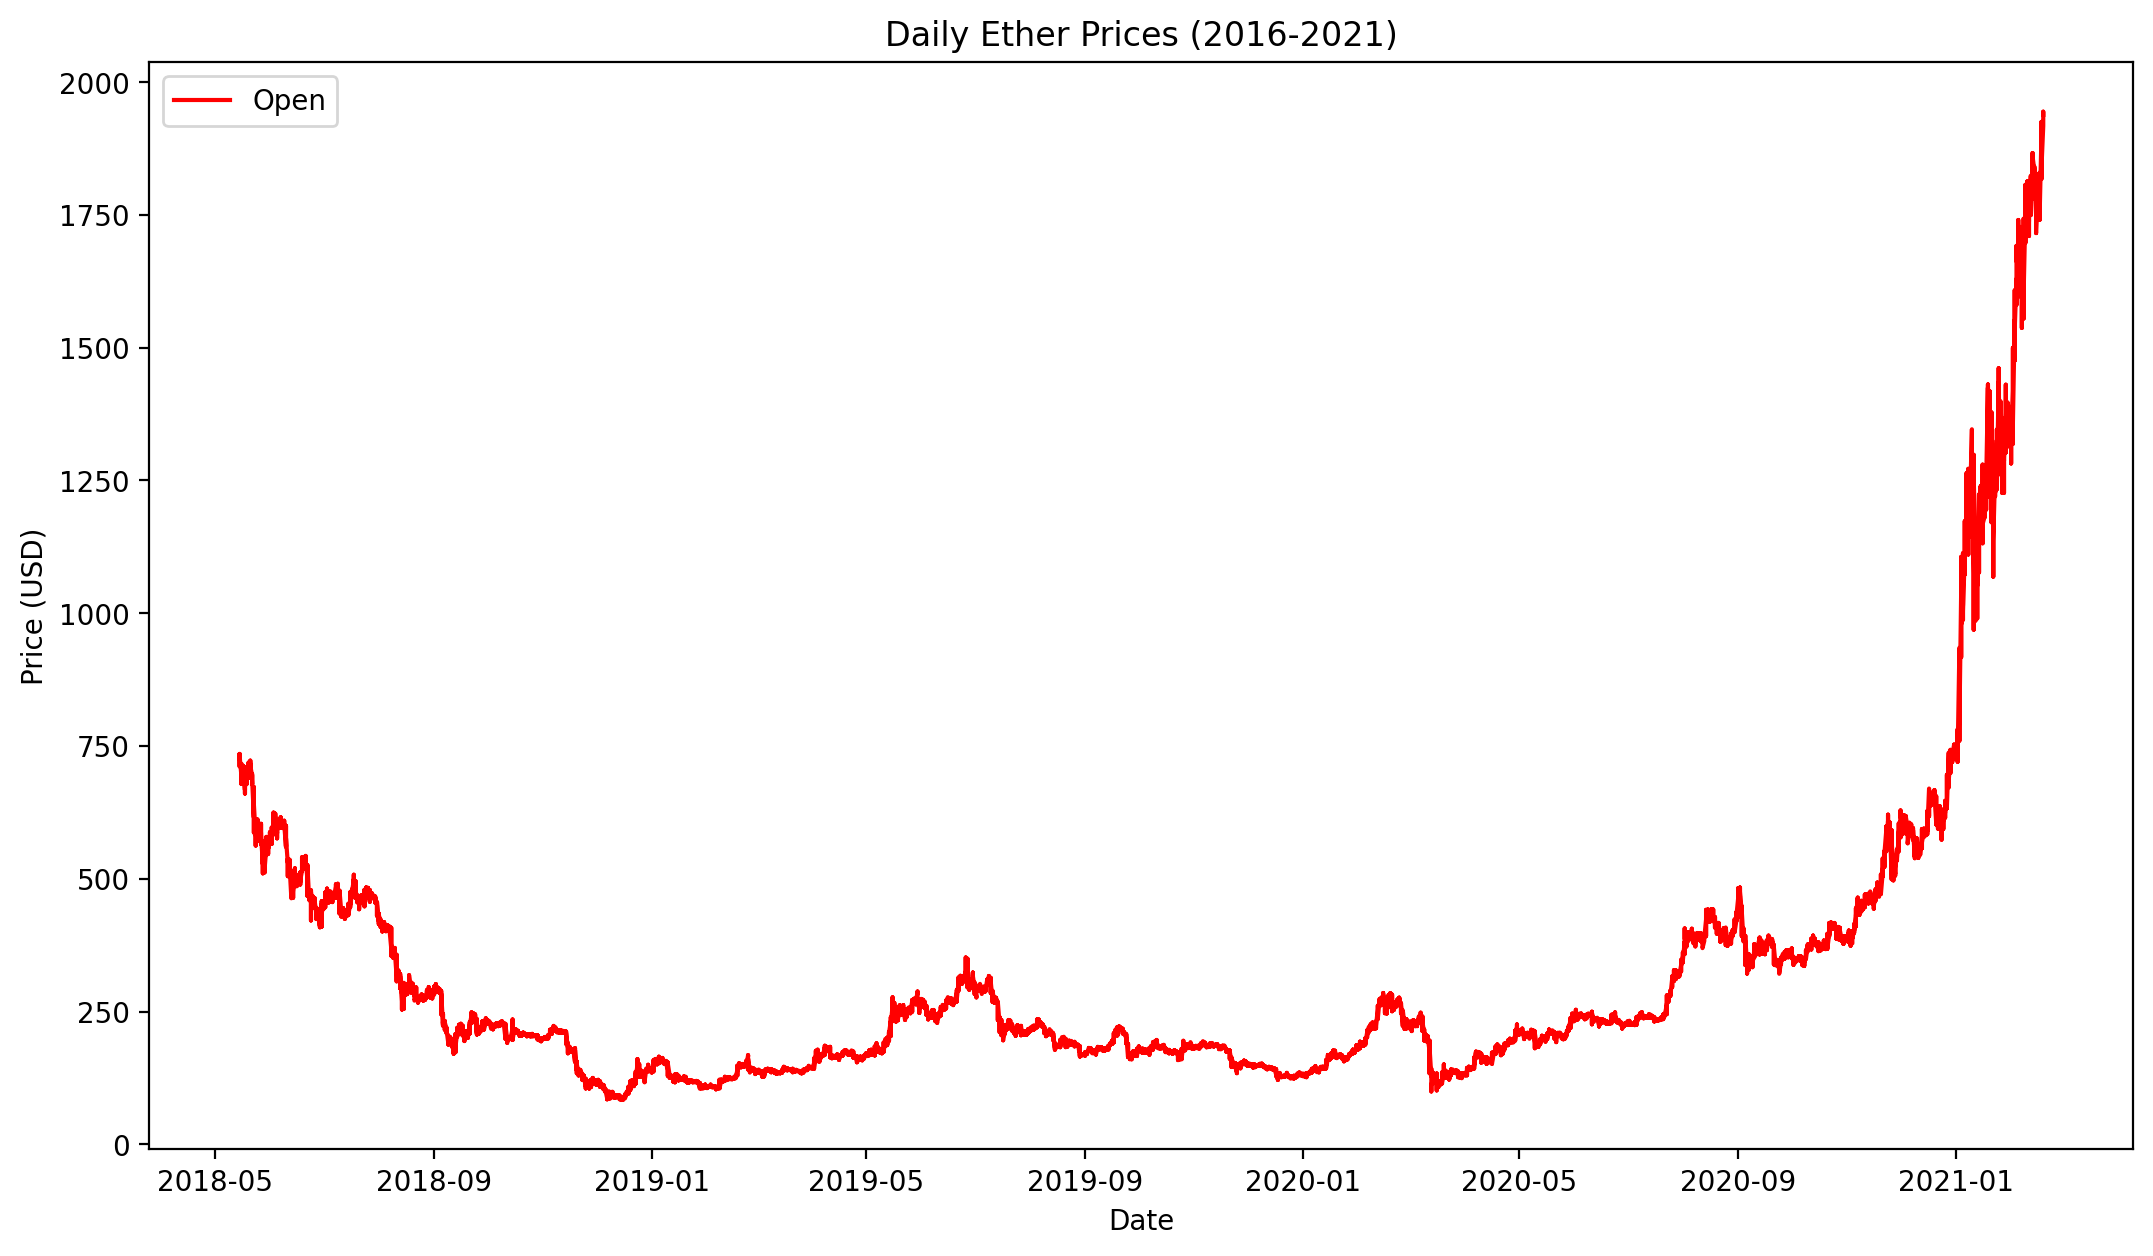

In [65]:
plot_time_series(((ether_data["Open"], "red", "Open"),), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

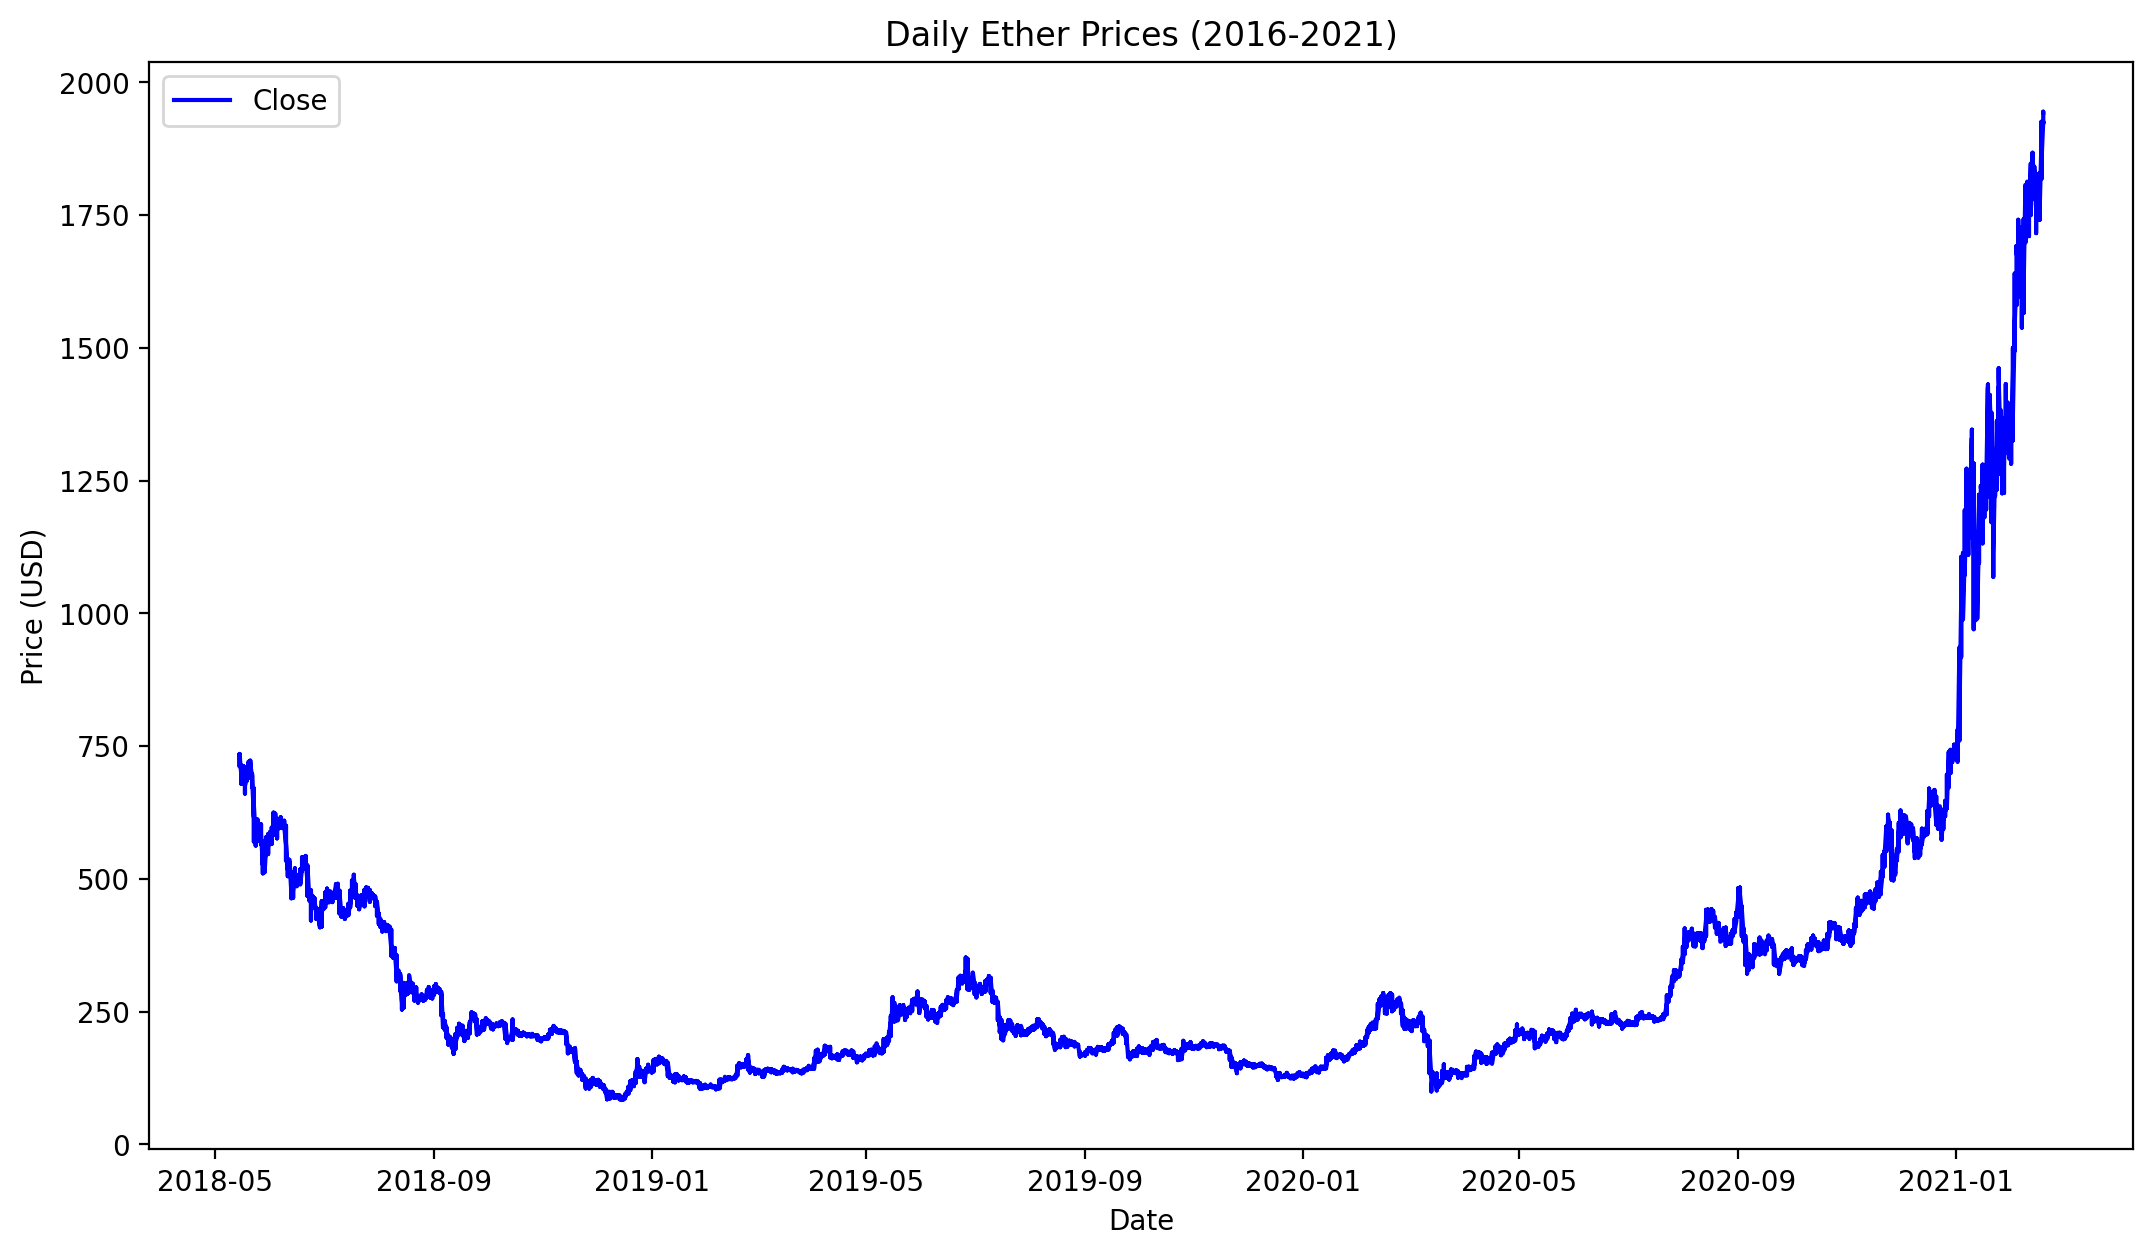

In [66]:
plot_time_series(((ether_data["Close"], "blue", "Close"),), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

In [67]:
rolling_mean = ether_data.rolling(window=2160).mean()
rolling_standard_deviation = ether_data.rolling(window=2160).std()
rolling_mean.dropna(axis=0, inplace=True)
rolling_mean.drop(labels=["Year", "Month", "Weekday"], axis=1, inplace=True)
rolling_standard_deviation.dropna(axis=0, inplace=True)
rolling_standard_deviation.drop(labels=["Year", "Month", "Weekday"], axis=1, inplace=True)

In [68]:
rolling_mean

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13,502.007921,504.671074,498.894421,501.804843,6974.951676
2018-08-13,501.815736,504.477509,498.700713,501.611083,6980.134704
2018-08-13,501.628935,504.293139,498.516903,501.427662,6984.367130
2018-08-13,501.445102,504.104514,498.332847,501.240829,6982.336407
2018-08-13,501.263787,503.918880,498.151819,501.057319,6976.620380
...,...,...,...,...,...
2021-02-19,1022.611915,1032.413356,1011.978662,1023.254406,8252.209453
2021-02-19,1023.262104,1033.066104,1012.629639,1023.906184,8249.716950
2021-02-19,1023.920151,1033.720340,1013.283384,1024.556748,8241.249028


In [69]:
rolling_standard_deviation

,Open,High,Low,Close,Volume
Date,,,,,
2018-08-13,89.875066,90.446709,89.292334,89.848445,7995.669540
2018-08-13,89.824460,90.397760,89.241995,89.800811,7998.524115
2018-08-13,89.782479,90.351501,89.208366,89.766217,8000.398443
2018-08-13,89.746925,90.309538,89.169562,89.723467,8000.691402
2018-08-13,89.717520,90.273494,89.138018,89.686441,7999.252184
...,...,...,...,...,...
2021-02-19,442.968919,447.389965,438.466509,443.270901,13106.415057
2021-02-19,443.279773,447.698055,438.792781,443.590006,13106.904378
2021-02-19,443.591728,448.000489,439.110452,443.899285,13105.543285


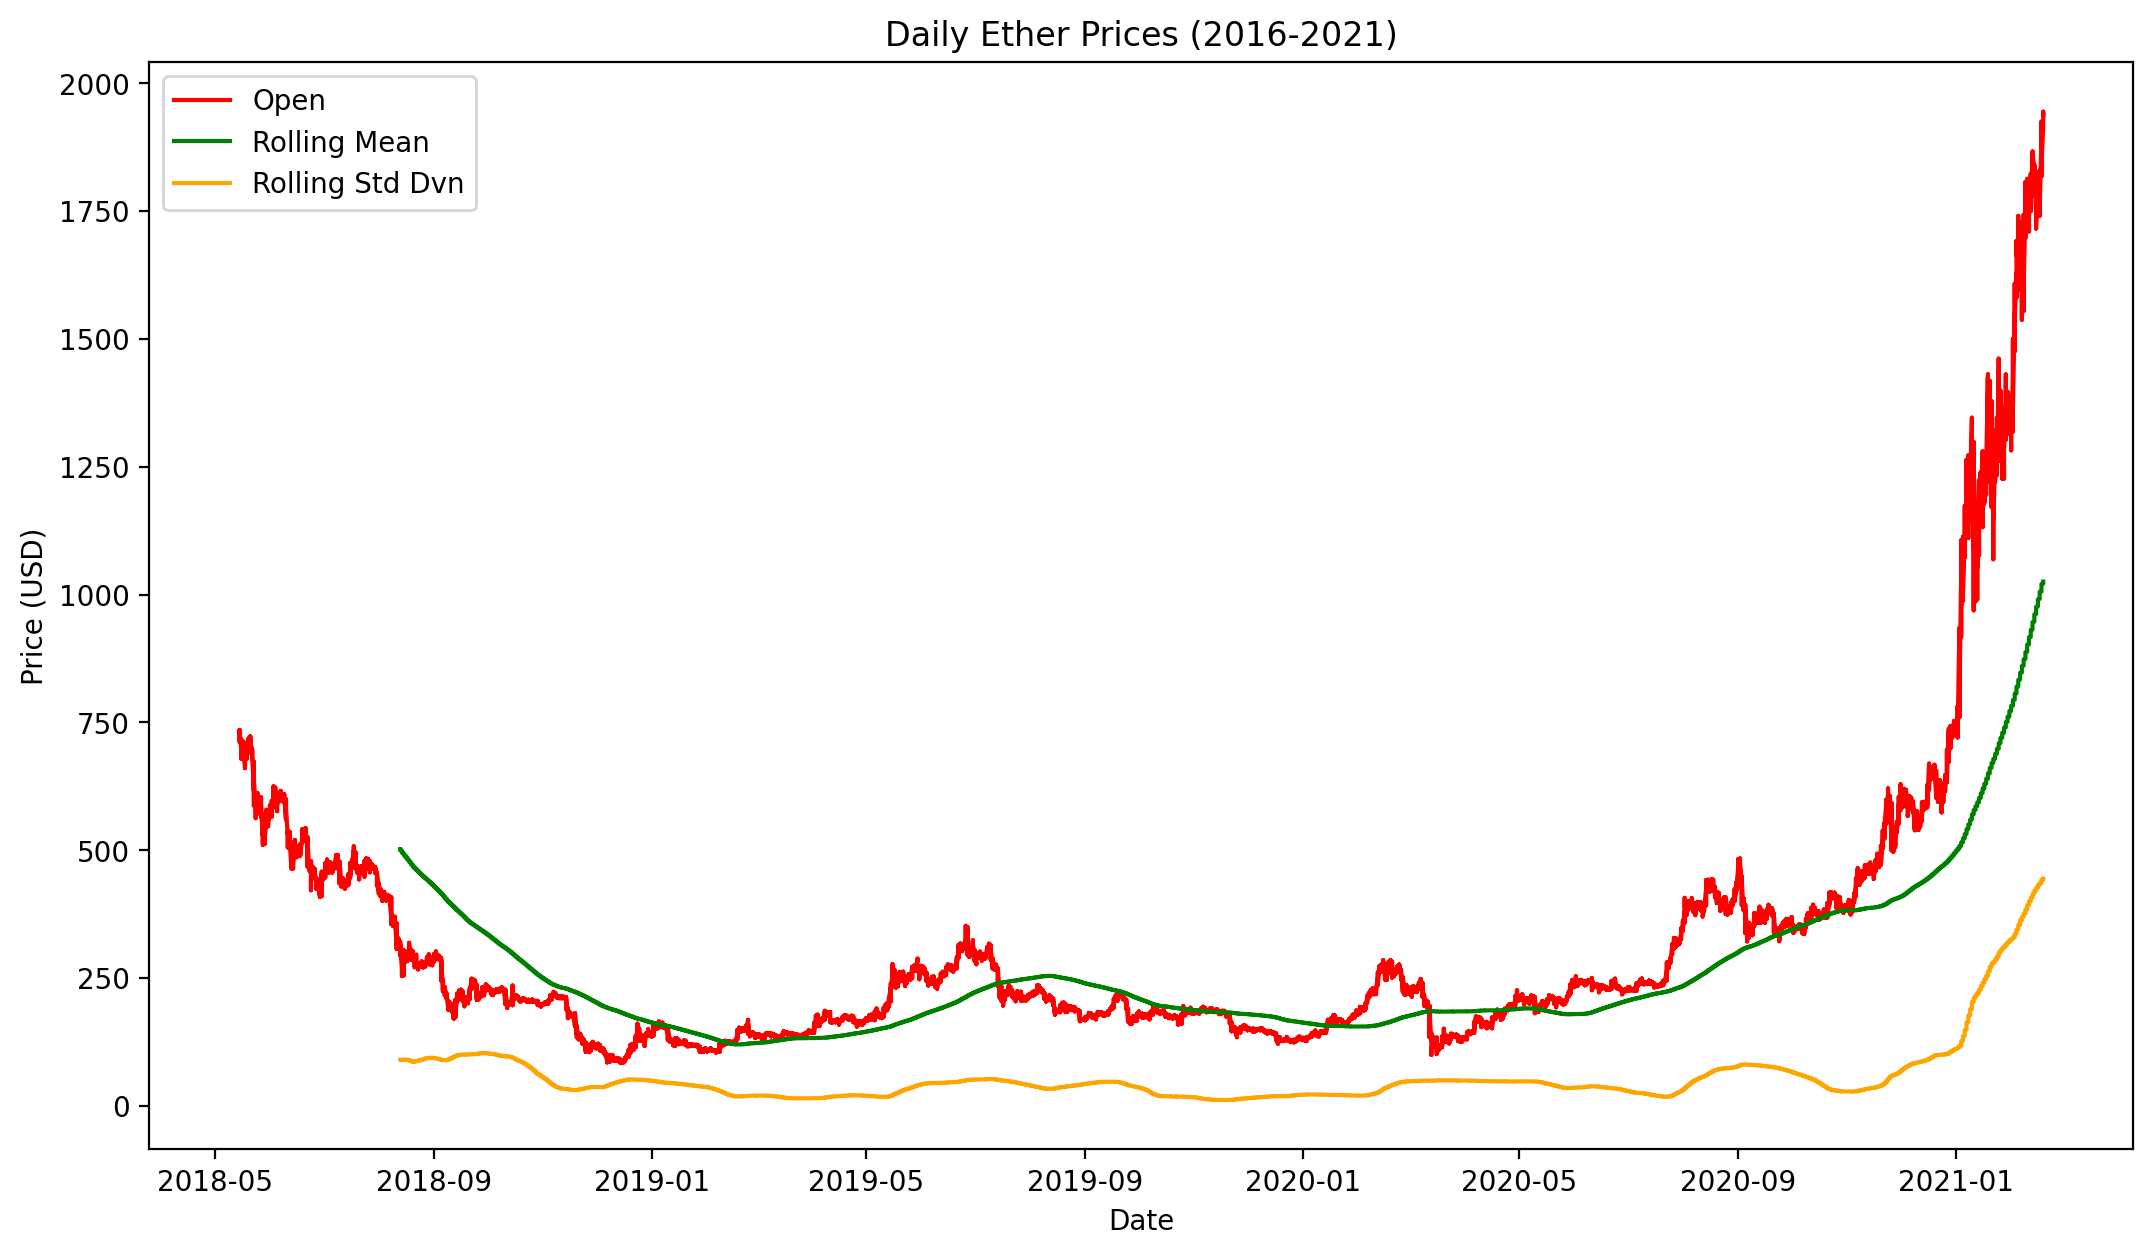

In [70]:
plot_time_series(((ether_data["Open"], "red", "Open"), (rolling_mean["Open"], "green", "Rolling Mean"), (rolling_standard_deviation["Open"], "orange", "Rolling Std Dvn")), "Date", "Price (USD)", "Daily Ether Prices (2016-2021)")

In [71]:
training_size = int(len(ether_data) * 0.80)
test_size = len(ether_data) - training_size
train_ether_data = ether_data[:training_size]
test_ether_data = ether_data[training_size:]
train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)

C:\Users\samee\AppData\Local\Temp\ipykernel_13912\3069994065.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)
C:\Users\samee\AppData\Local\Temp\ipykernel_13912\3069994065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ether_data.drop(labels=column_sequence[:3] + column_sequence[4:], axis=1, inplace=True)


In [72]:
train_ether_data

,Open
Date,
2018-05-15,733.12
2018-05-15,723.64
2018-05-15,717.43
2018-05-15,711.72
2018-05-15,729.61
...,...
2020-07-31,335.43
2020-08-01,355.34
2020-08-01,361.65


In [73]:
test_ether_data

,Open
Date,
2020-08-01,352.60
2020-08-01,357.00
2020-08-01,356.17
2020-08-01,354.75
2020-08-01,359.41
...,...
2021-02-19,1922.20
2021-02-19,1936.90
2021-02-19,1944.40


In [74]:
# min_max_scaler = MinMaxScaler(feature_range=(0,1))
# scaled_train = min_max_scaler.fit_transform(train_ether_data)
# scaled_test = min_max_scaler.fit_transform(test_ether_data)
standard_scaler = StandardScaler()
scaled_train = standard_scaler.fit_transform(train_ether_data)
scaled_test = standard_scaler.fit_transform(test_ether_data)

In [108]:
scaled_train.shape

(19407, 1)

In [109]:
scaled_test.shape

(4852, 1)

In [77]:
lstm_train_x, lstm_train_y = prepare_for_lstm(scaled_train, 24)
lstm_test_x, lstm_test_y = prepare_for_lstm(scaled_test, 24)
lstm_train_x = np.reshape(lstm_train_x, (lstm_train_x.shape[0], lstm_train_x.shape[1], 1))
lstm_test_x = np.reshape(lstm_test_x, (lstm_test_x.shape[0], lstm_test_x.shape[1], 1))

In [111]:
lstm_train_y.shape

(19383,)

In [79]:
lstm_test_y.shape

(4828,)

In [80]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=128, activation="linear", return_sequences=True, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=64, input_shape=(lstm_train_x.shape[1], lstm_train_x.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 128)           66560     
                                                                 
 dropout_4 (Dropout)         (None, 24, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer="adam", loss="mean_squared_error")
training_result = model.fit(lstm_train_x, lstm_train_y, batch_size=256, epochs=50, verbose=1, shuffle=False, validation_data=(lstm_test_x, lstm_test_y), callbacks=None)

Epoch 1/50
76/76 [==============================] - 12s 123ms/step - loss: 0.3270 - val_loss: 0.0199
Epoch 2/50
76/76 [==============================] - 9s 115ms/step - loss: 0.0685 - val_loss: 0.0323
Epoch 3/50
76/76 [==============================] - 9s 117ms/step - loss: 0.0561 - val_loss: 0.0439
Epoch 4/50
76/76 [==============================] - 9s 123ms/step - loss: 0.0481 - val_loss: 0.0363
Epoch 5/50
76/76 [==============================] - 8s 105ms/step - loss: 0.0275 - val_loss: 0.0206
Epoch 6/50
76/76 [==============================] - 8s 106ms/step - loss: 0.0292 - val_loss: 0.0344
Epoch 7/50
76/76 [==============================] - 8s 101ms/step - loss: 0.0264 - val_loss: 0.0225
Epoch 8/50
76/76 [==============================] - 8s 110ms/step - loss: 0.0562 - val_loss: 0.0274
Epoch 9/50
76/76 [==============================] - 9s 114ms/step - loss: 0.0503 - val_loss: 0.0415
Epoch 10/50
76/76 [==============================] - 9s 113ms/step - loss: 0.0426 - val_loss: 0.035

In [82]:
training_result.history

{'loss': [0.3269941806793213,
  0.06849536299705505,
  0.056145839393138885,
  0.04813363030552864,
  0.02745778113603592,
  0.029200254008173943,
  0.02638501487672329,
  0.056164517998695374,
  0.050322141498327255,
  0.0426347590982914,
  0.025156170129776,
  0.014252841472625732,
  0.042698364704847336,
  0.030630718916654587,
  0.02194145694375038,
  0.014530454762279987,
  0.009976712055504322,
  0.010803998447954655,
  0.009720472618937492,
  0.008942781947553158,
  0.010137327946722507,
  0.010550676845014095,
  0.009674182161688805,
  0.009020807221531868,
  0.008990451693534851,
  0.009223461151123047,
  0.009525883942842484,
  0.008888814598321915,
  0.009250991977751255,
  0.01004290021955967,
  0.00961980875581503,
  0.010319883935153484,
  0.011007076129317284,
  0.011543306522071362,
  0.011631458066403866,
  0.011803350411355495,
  0.014009875245392323,
  0.012395471334457397,
  0.011051608249545097,
  0.014145567081868649,
  0.01887672208249569,
  0.013921849429607391,

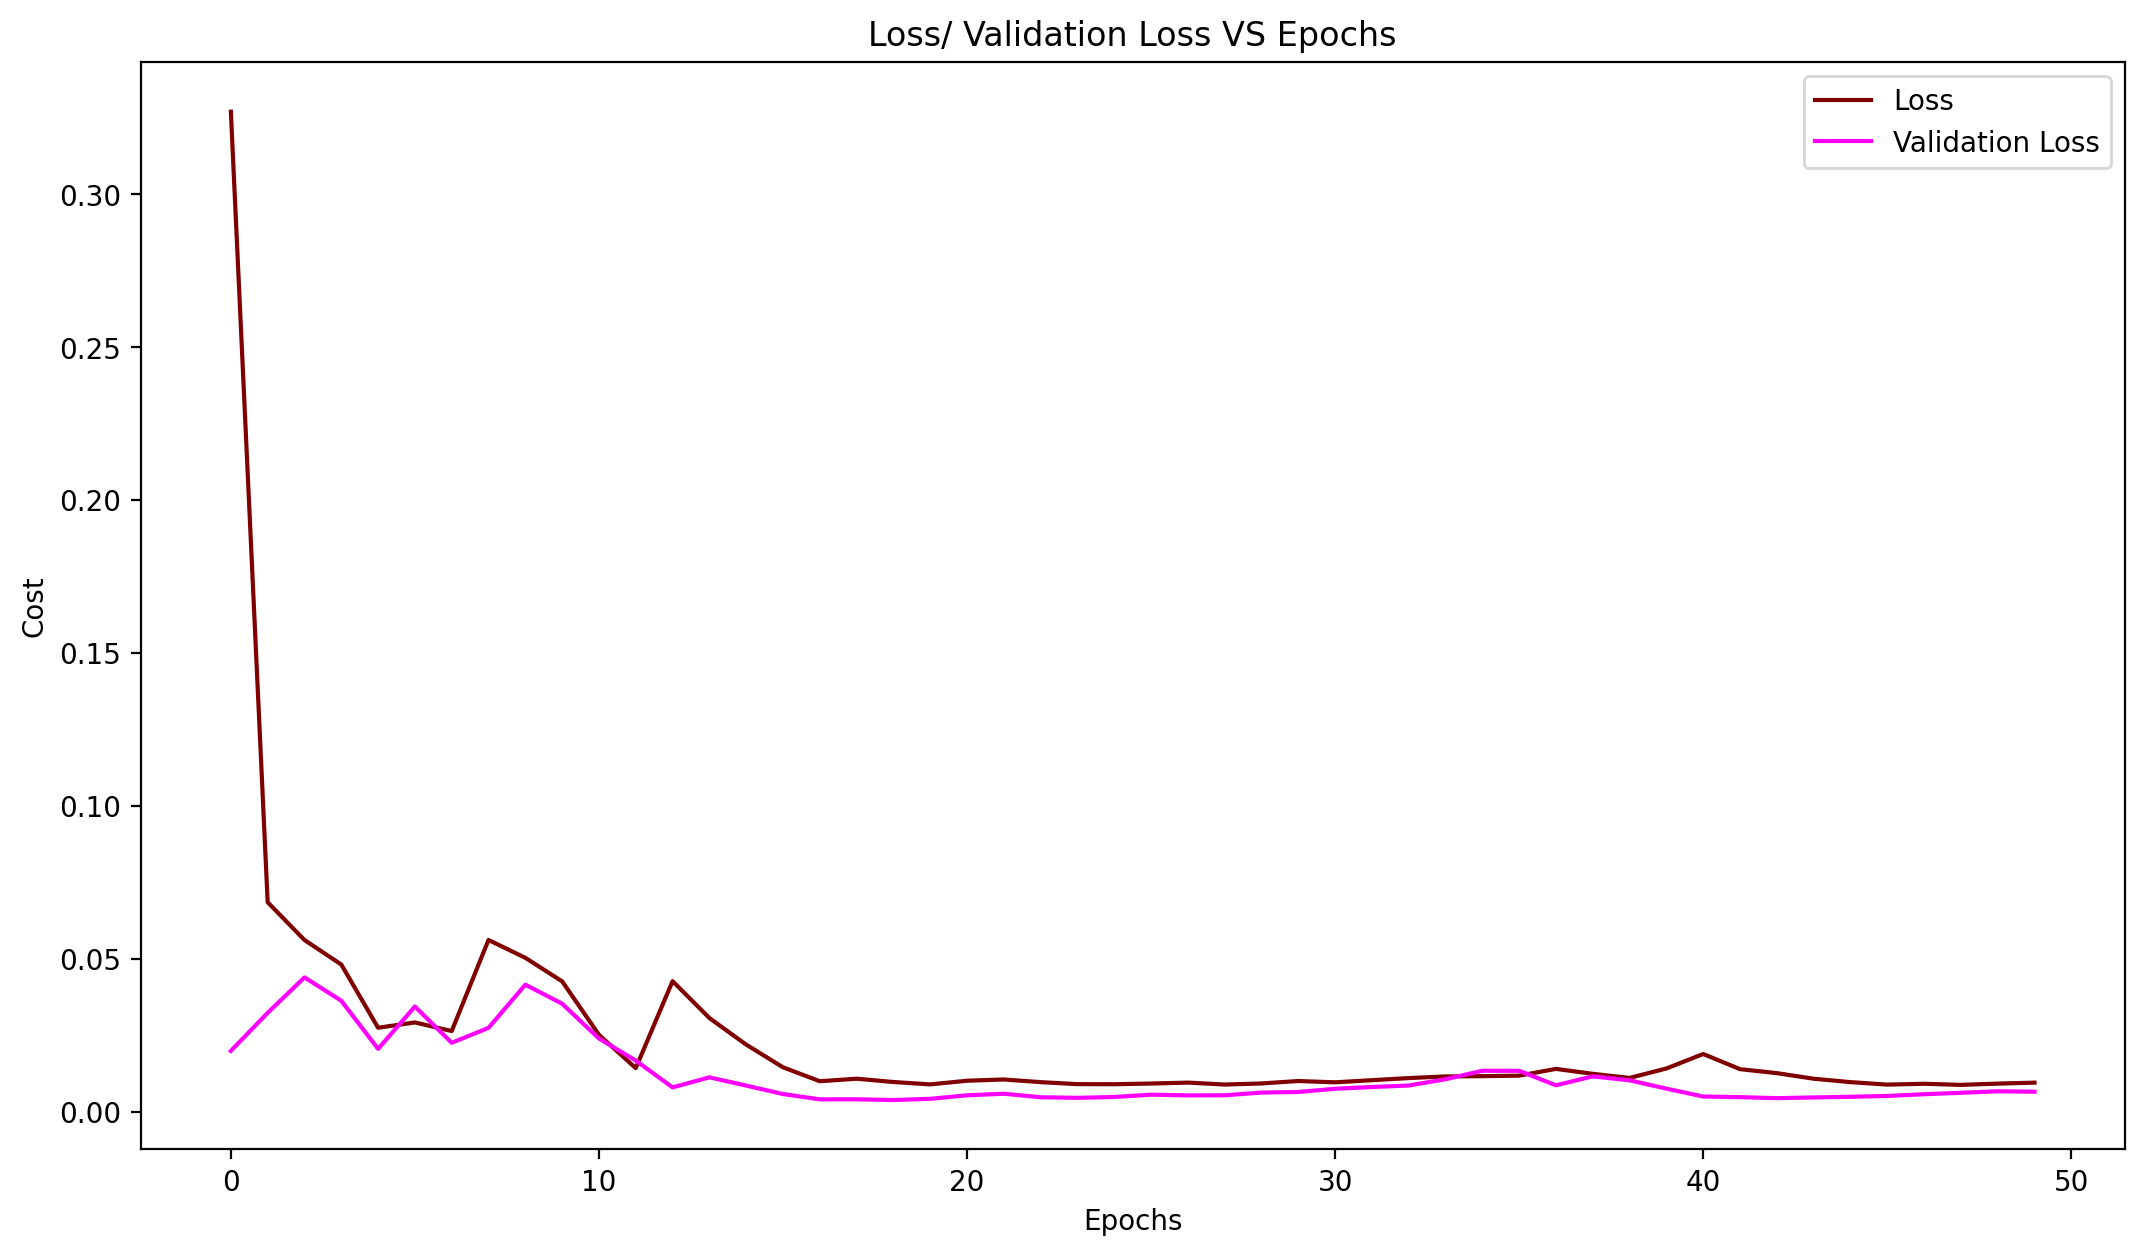

In [83]:
plot_time_series(((training_result.history["loss"], "maroon", "Loss"), (training_result.history["val_loss"], "magenta", "Validation Loss")), "Epochs", "Cost", "Loss/ Validation Loss VS Epochs")

In [99]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted)/actual))*100

In [106]:
# actual_ether_data = min_max_scaler.inverse_transform(lstm_test_y.reshape(-1, 1))
# predicted_ether_data = model.predict(lstm_test_x)
# predicted_ether_data = min_max_scaler.inverse_transform(predicted_ether_data.reshape(-1, 1))
actual_ether_data = standard_scaler.inverse_transform(lstm_test_y.reshape(-1, 1))
predicted_ether_data = model.predict(lstm_test_x)
predicted_ether_data = standard_scaler.inverse_transform(predicted_ether_data.reshape(-1, 1))

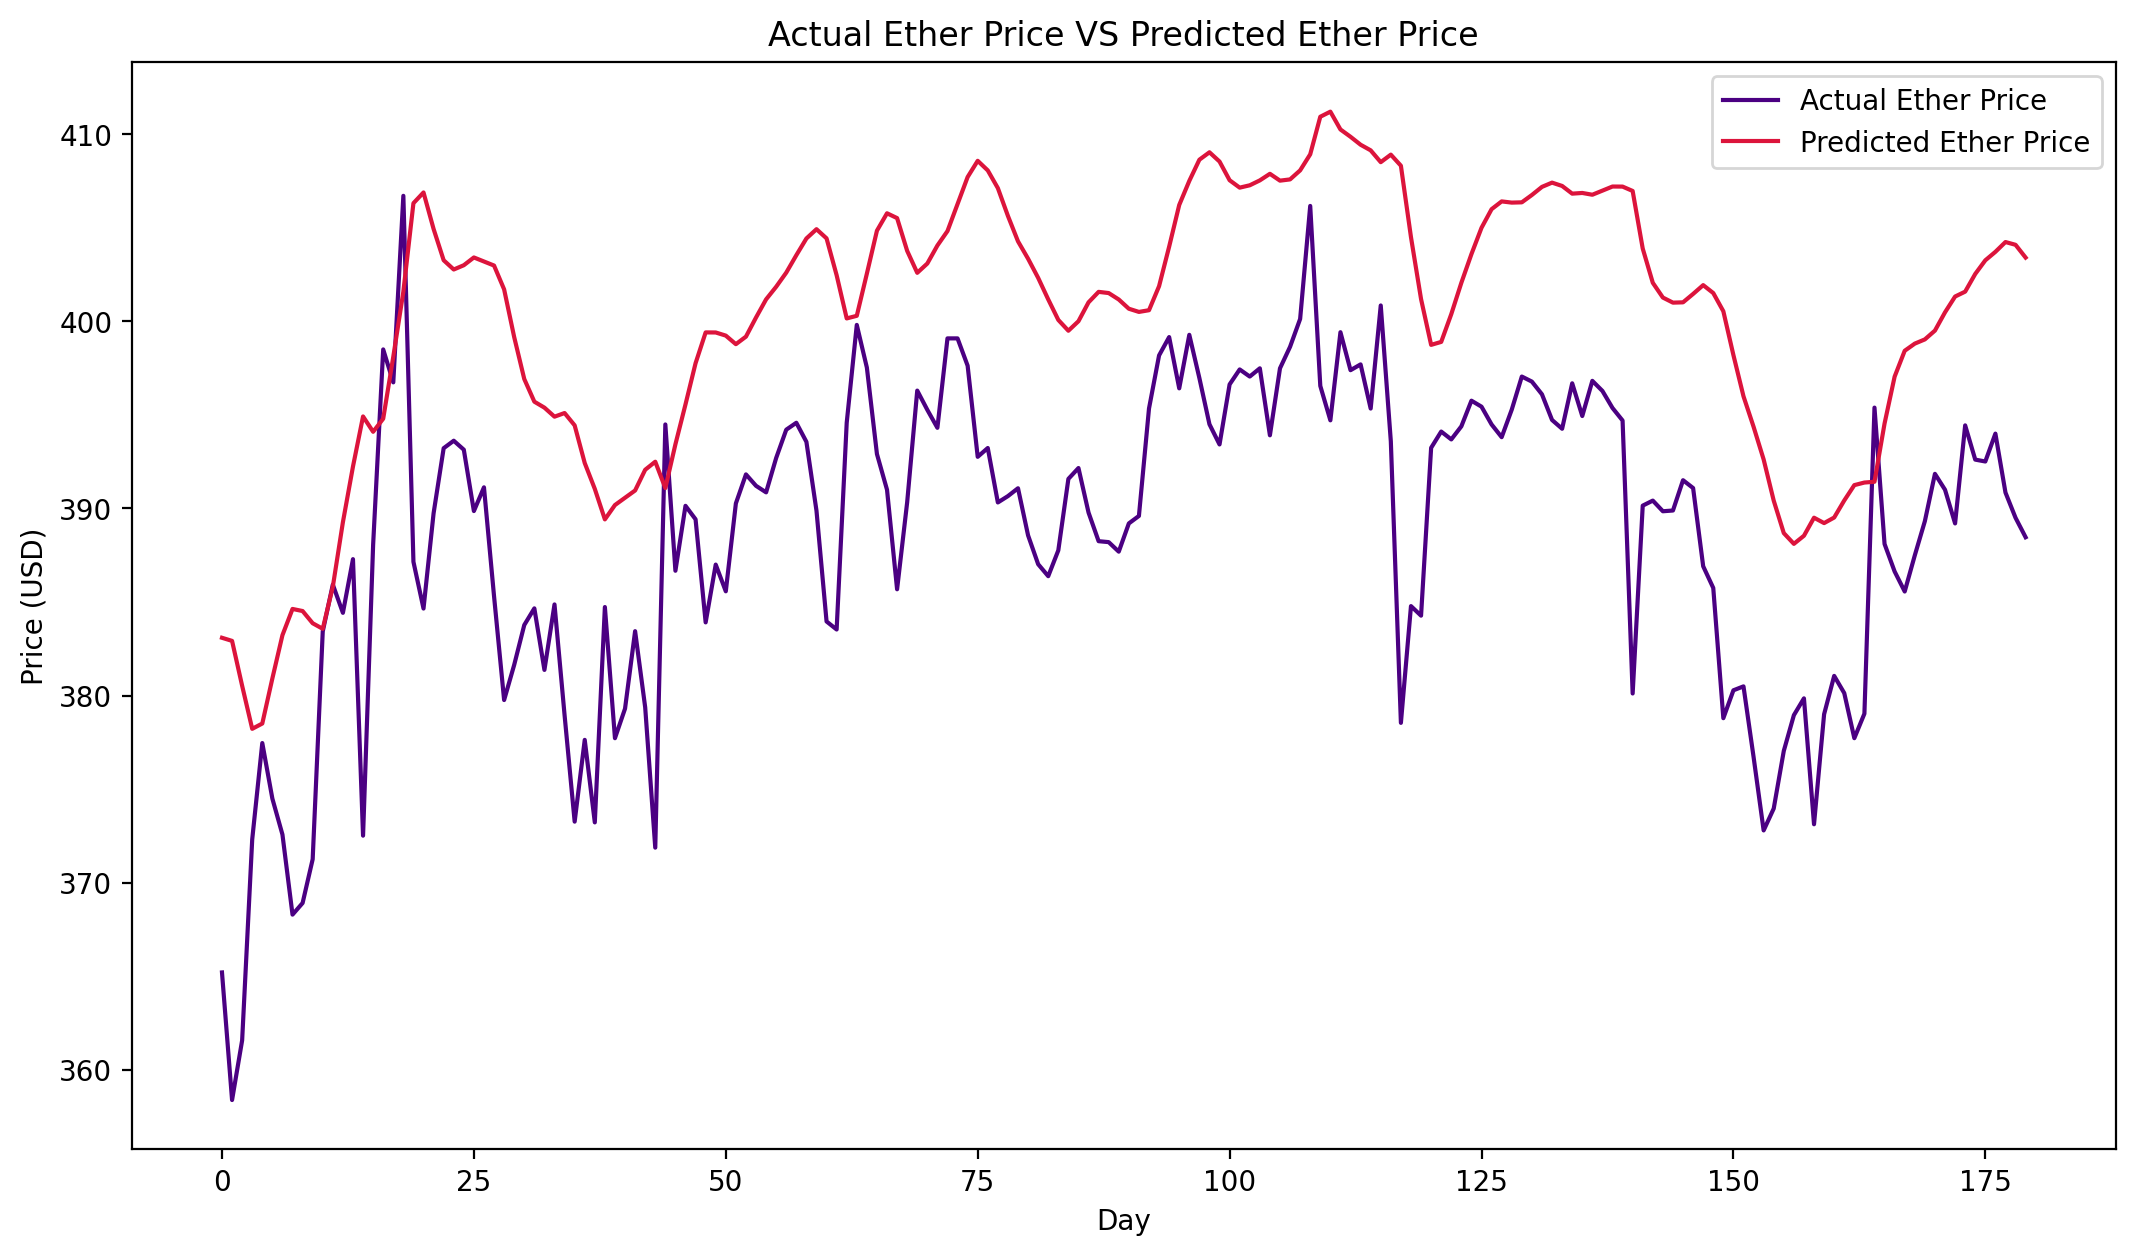

In [114]:
plot_time_series(((actual_ether_data[:180], "indigo", "Actual Ether Price"), (predicted_ether_data[:180], "crimson", "Predicted Ether Price")), "Day", "Price (USD)", "Actual Ether Price VS Predicted Ether Price")